In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import anndata as ad 
import scanpy as sc
sys.path.append("../../../../")

import utils
from sklearn.decomposition import PCA
import umap
import graph
import visualize
import utils
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import os
from matplotlib.pyplot import figure
figure(figsize=(8, 8), dpi=150)

from pySankey import sankey

/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<Figure size 1200x1200 with 0 Axes>

In [2]:
# read in files
cnngnn_embed = np.load("../data/double_snap_combo_stable_binVer_0325.npy")
snap = pd.DataFrame(cnngnn_embed)
snap.to_csv('../data/double_snap_combo_stable_binVer_0325.csv')

res05_input = np.load('../data/feature_labels_res0.5.npy')
## df_clean original location
load_path = '/mnt/cloud1/sheng-projects/st_projects/spatial_clust/data/tonsil/'
metaload_path = '/mnt/cloud1/sheng-projects/st_projects/spatial_clust/data/tonsil/processed_data/meta_data/'
df_clean = pd.read_csv(os.path.join(metaload_path , "features_and_metadata.csv"), index_col=0) # already cleaned
xrange = [ 4, 5, 6, 7, 8]
yrange = [8, 9, 10, 11, 12, 13]
df_clean = df_clean[df_clean["X_view"].isin(xrange) & df_clean["Y_view"].isin(yrange)]
df_clean.shape

(102574, 55)

<AxesSubplot: xlabel='centroid_x', ylabel='centroid_y'>

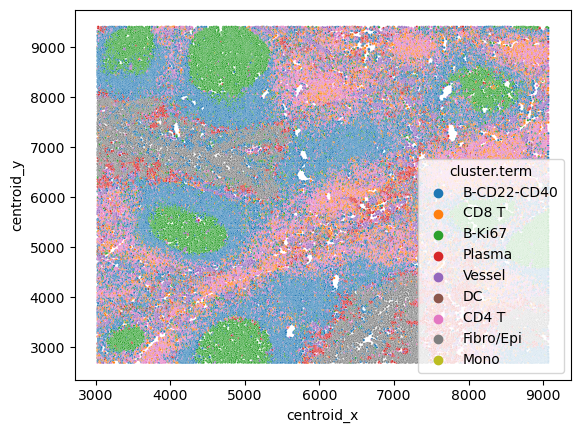

In [3]:
tp = df_clean.copy()

sns.scatterplot(data=tp, x="centroid_x", y="centroid_y", hue="cluster.term", s = 3)

In [34]:
from scipy.stats import entropy

def cluster_refine(label, label_ref, entropy_threshold = 0.75, concen_threshold = 1, max_breaks = 3, size_lim = 50):
    label_out = label.copy()
    label_out.name = label_out.name + '-refined'
    label_out = label_out.astype(str)
    ll = np.unique(label)
    for l in ll: # each cluster
        ref_l = label_ref[label == l] # get input cluster
        ref_l_freq = ref_l.value_counts() # table
        if entropy(ref_l_freq) > entropy_threshold: # if high entro
            for i in np.arange(max_breaks-1):
                bb = label[label_ref == ref_l_freq.index[i]] # get most abun input cluster
                #print([i, ref_l_freq, ref_l_freq.iloc[i]])
                if entropy(bb.value_counts()) < concen_threshold and ref_l_freq.iloc[i] >= size_lim:
                    label_out[(label == l) & (label_ref == ref_l_freq.index[i])] = l + '-' + str(i)
    
    return label_out.astype('category')

### another help to clean results
def clean_cluster(label):
    ll = label.value_counts().index.to_list()
    i = 0
    dd = {}
    for l in ll:
        dd[l] = str(i)
        i = i+1
    res = []
    for item in label:
        t = dd[item]
        res.append(t)
    return res

### convGNN clustering

In [36]:
cnngnn_adata = ad.AnnData(utils.drop_zero_variability_columns(cnngnn_embed))
sc.pp.scale(cnngnn_adata)
sc.pp.neighbors(cnngnn_adata, n_neighbors=15, use_rep='X')
sc.tl.umap(cnngnn_adata)
sc.tl.leiden(cnngnn_adata, resolution=1)
# plot
#fig = plot.get_figure()
#plt.rcParams["figure.figsize"] = (6, 6)
#sc.pl.umap(cnngnn_adata, color='leiden', legend_fontsize=17, show=False, palette='tab20',
#          legend_loc= 'on data')

# cellsnap cluster guarding
cnngnn_adata.obs['input'] = res05_input
snapres1 = cluster_refine(label = cnngnn_adata.obs['leiden'], label_ref=cnngnn_adata.obs['input'])
snapres1f = clean_cluster(snapres1)

/tmp/ipykernel_417583/2649069676.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  cnngnn_adata = ad.AnnData(utils.drop_zero_variability_columns(cnngnn_embed))


/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<AxesSubplot: title={'center': 'snapres1'}, xlabel='UMAP1', ylabel='UMAP2'>

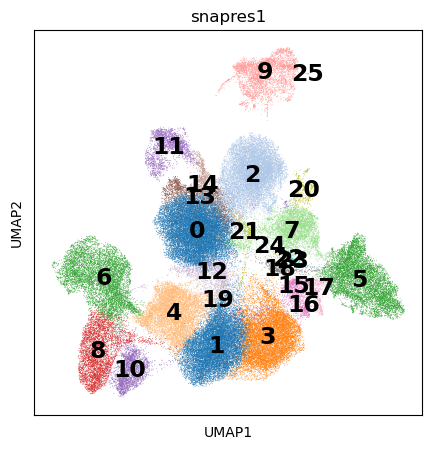

In [37]:
snapres1.value_counts()
plt.rcParams["figure.figsize"] = (5, 5)
cnngnn_adata.obs['snapres1'] = snapres1f
sc.pl.umap(cnngnn_adata, color='snapres1', legend_fontsize=17, show=False, palette='tab20',
          legend_loc= 'on data')

### annotation

/tmp/ipykernel_417583/1928585837.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp = df_train.groupby(by='snap_label_res1').mean()


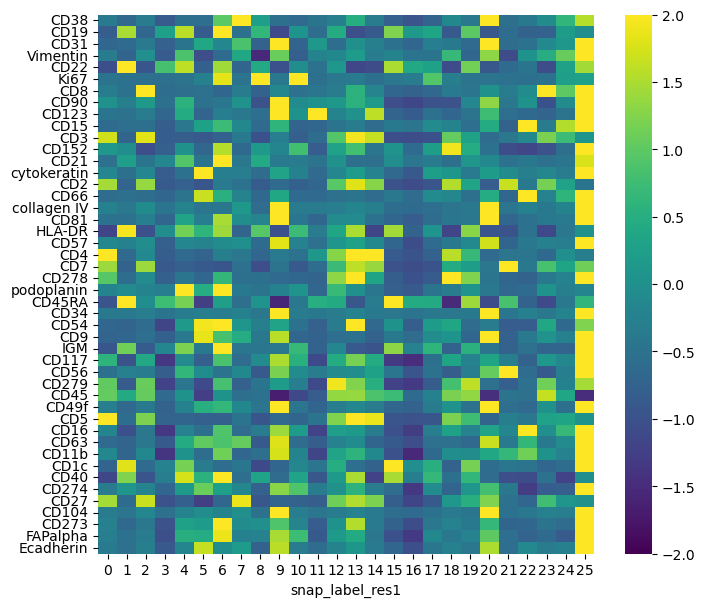

In [41]:
# annotate based on feature expressions
from scipy import stats

df_clean = pd.read_csv(os.path.join(metaload_path , "features_and_metadata.csv"), index_col=0) # already cleaned
xrange = [ 4, 5, 6, 7, 8]
yrange = [8, 9, 10, 11, 12, 13]
df_clean = df_clean[df_clean["X_view"].isin(xrange) & df_clean["Y_view"].isin(yrange)]

#### stupid as fuck
df_train = df_clean
df_train['snap_label_res1'] = cnngnn_adata.obs['snapres1'].values
df_train = df_train.drop(['cellLabelInImage', 'HOECHST1', 'cellSize',
                'X_view', 'Y_view', 'centroid_x', 'centroid_y', 'PointNum', 'cluster.term'], axis=1)
tmp = df_train.groupby(by='snap_label_res1').mean()
plt.rcParams["figure.figsize"] = (8, 7)
plot = sns.heatmap((stats.zscore(tmp, axis=0, ddof=0)).T, cmap="viridis", vmin=-2, vmax=2, yticklabels=True, xticklabels=True)
fig = plot.get_figure()
fig.savefig('../plots/snap_heatmap_0325.svg', dpi = 150) 

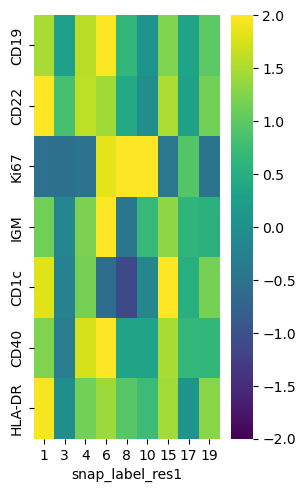

In [43]:
# also we can do a b cell only
tempb = (stats.zscore(tmp, axis=0, ddof=0)).T
#tempb
tempb = tempb.loc[['CD19', 'CD22', 'Ki67', 'IGM', 'CD1c', 'CD40', 'HLA-DR'],['1','3','4','6','8','10','15','17','19']]

plot2 = sns.heatmap(tempb, cmap="viridis", vmin=-2, vmax=2)
fig = plot2.get_figure()
plt.rcParams["figure.figsize"] = (3, 5.5)
fig.savefig('../plots/tonsil_snapres1_heatmap_Bonly_0325.svg', dpi = 100) 

In [51]:
## add 
df_clean['snap_label_res1'] = df_train['snap_label_res1']
df_clean['snap_label_res1_ann'] = df_train['snap_label_res1']

new_cluster_names = {
    '0':'CD4', '1':'B', '2':'CD8', '3':'B', '4':'B', '5':'Fibro/Epi',
    '6':'B', '7':'Plasma', '8':'B', '9':'Vessel', '10':'B', '11':'DC',
    '12':'CD4', '13':'CD4', '14':'CD4', '15':'B', '16':'Other', '17':'B',
    '18':'CD4', '19':'B', '20':'Vessel', '21':'NK', '22':'Neutrophil', '23':'CD8', '24':'Neutrophil',
    '25':'Other'
}

df_clean=df_clean.replace({"snap_label_res1_ann": new_cluster_names})
#df_clean.head()

/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<AxesSubplot: title={'center': 'cnnann'}, xlabel='UMAP1', ylabel='UMAP2'>

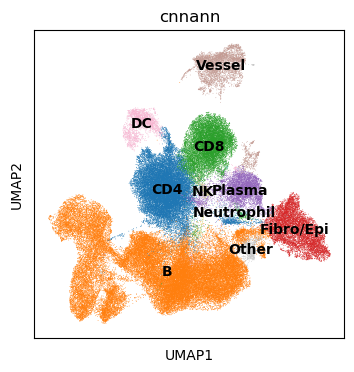

In [53]:
# plot
plt.rcParams["figure.figsize"] = (4, 4)
cnngnn_adata.obs['cnnann'] = df_clean['snap_label_res1_ann'].values
sc.pl.umap(cnngnn_adata, color='cnnann', legend_fontsize=10, show=False, palette='tab20',
          legend_loc= 'on data')

/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<AxesSubplot: title={'center': 'orig'}, xlabel='UMAP1', ylabel='UMAP2'>

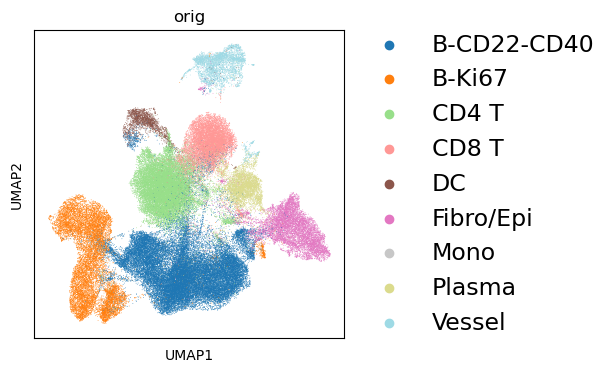

In [54]:
# plot
plt.rcParams["figure.figsize"] = (4, 4)
cnngnn_adata.obs['orig'] = df_clean['cluster.term'].values
sc.pl.umap(cnngnn_adata, color='orig', legend_fontsize=17, show=False, palette='tab20')

## feature clustereing

In [56]:
df_clean.columns

Index(['cellLabelInImage', 'cellSize', 'HOECHST1', 'CD38', 'CD19', 'CD31',
       'Vimentin', 'CD22', 'Ki67', 'CD8', 'CD90', 'CD123', 'CD15', 'CD3',
       'CD152', 'CD21', 'cytokeratin', 'CD2', 'CD66', 'collagen IV', 'CD81',
       'HLA-DR', 'CD57', 'CD4', 'CD7', 'CD278', 'podoplanin', 'CD45RA', 'CD34',
       'CD54', 'CD9', 'IGM', 'CD117', 'CD56', 'CD279', 'CD45', 'CD49f', 'CD5',
       'CD16', 'CD63', 'CD11b', 'CD1c', 'CD40', 'CD274', 'CD27', 'CD104',
       'CD273', 'FAPalpha', 'Ecadherin', 'PointNum', 'cluster.term',
       'centroid_x', 'centroid_y', 'X_view', 'Y_view', 'snap_label_res1',
       'snap_label_res1_ann'],
      dtype='object')

/tmp/ipykernel_417583/427454166.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  feature_adata = ad.AnnData(df_clean.iloc[:,3:-8]) # remove meta info
/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<AxesSubplot: title={'center': 'leiden'}, xlabel='UMAP1', ylabel='UMAP2'>

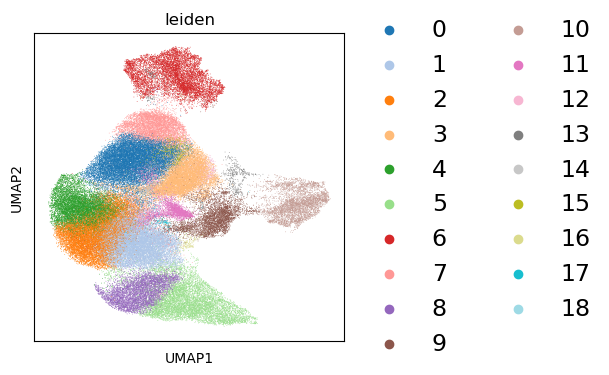

In [57]:
feature_adata = ad.AnnData(df_clean.iloc[:,3:-8]) # remove meta info
sc.pp.scale(feature_adata)
sc.pp.neighbors(feature_adata, n_neighbors=15, use_rep='X')
sc.tl.umap(feature_adata)
sc.tl.leiden(feature_adata, resolution=1)
# plot
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(feature_adata, color='leiden', legend_fontsize=17, show=False, palette='tab20')

In [59]:
df_clean.columns

Index(['cellLabelInImage', 'cellSize', 'HOECHST1', 'CD38', 'CD19', 'CD31',
       'Vimentin', 'CD22', 'Ki67', 'CD8', 'CD90', 'CD123', 'CD15', 'CD3',
       'CD152', 'CD21', 'cytokeratin', 'CD2', 'CD66', 'collagen IV', 'CD81',
       'HLA-DR', 'CD57', 'CD4', 'CD7', 'CD278', 'podoplanin', 'CD45RA', 'CD34',
       'CD54', 'CD9', 'IGM', 'CD117', 'CD56', 'CD279', 'CD45', 'CD49f', 'CD5',
       'CD16', 'CD63', 'CD11b', 'CD1c', 'CD40', 'CD274', 'CD27', 'CD104',
       'CD273', 'FAPalpha', 'Ecadherin', 'PointNum', 'cluster.term',
       'centroid_x', 'centroid_y', 'X_view', 'Y_view', 'snap_label_res1',
       'snap_label_res1_ann', 'feature_label_res1'],
      dtype='object')

/tmp/ipykernel_417583/2455902504.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp = df_train.groupby(by='feature_label_res1').mean()


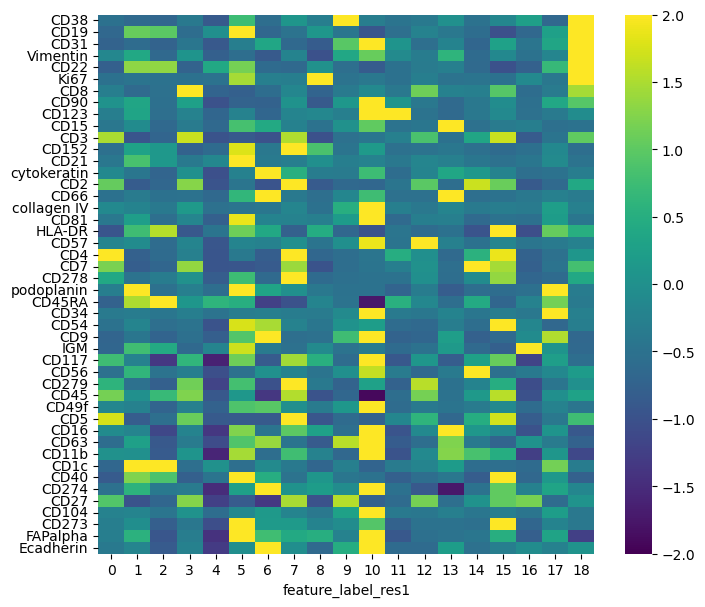

In [61]:
# annotate based on feature expressions
from scipy import stats
df_train = df_clean
df_train['feature_label_res1'] = feature_adata.obs['leiden'].values
df_train = df_train.drop(['cellLabelInImage', 'HOECHST1', 'cellSize',
                'X_view', 'Y_view', 'centroid_x', 'centroid_y', 'PointNum', 'cluster.term',
                        'snap_label_res1', 'snap_label_res1',
       'snap_label_res1_ann'], axis=1)
tmp = df_train.groupby(by='feature_label_res1').mean()
plot = sns.heatmap((stats.zscore(tmp, axis=0, ddof=0)).T, cmap="viridis", vmin=-2, vmax=2, yticklabels=True)
fig = plot.get_figure()

plt.rcParams["figure.figsize"] = (8, 7)
fig.savefig('../plots/feat_heatmap_0325.svg', dpi = 150) 

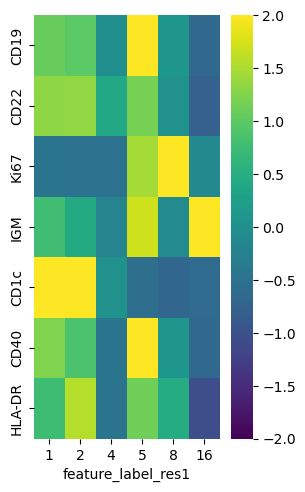

In [64]:
# also we can do a b cell only
tempb = (stats.zscore(tmp, axis=0, ddof=0)).T
#tempb
tempb = tempb.loc[['CD19', 'CD22', 'Ki67', 'IGM', 'CD1c', 'CD40', 'HLA-DR'],['1','2','4','5','8','16']]

plot2 = sns.heatmap(tempb, cmap="viridis", vmin=-2, vmax=2)
fig = plot2.get_figure()
plt.rcParams["figure.figsize"] = (3, 5.5)
fig.savefig('../plots/tonsil_featres1_heatmap_Bonly_0325.svg', dpi = 100) 

In [65]:
## add 
df_clean['feature_label_res1'] = df_train['feature_label_res1']
df_clean['feature_label_res1_ann'] = df_train['feature_label_res1']

new_cluster_names = {
    '0':'CD4', '1':'B', '2':'B', '3':'CD8', '4':'B', '5':'B',
    '6':'Fibro/Epi', '7':'CD4', '8':'B', '9':'Plasma', '10':'Vessel', '11':'DC',
    '12':'CD8', '13':'Neutrophil', '14':'NK', '15':'Other', '16':'B', '17':'Fibro/Epi',
    '18':'Dirt'
}

df_clean=df_clean.replace({"feature_label_res1_ann": new_cluster_names})
df_clean.head()

,cellLabelInImage,cellSize,HOECHST1,CD38,CD19,CD31,Vimentin,CD22,Ki67,CD8,...,PointNum,cluster.term,centroid_x,centroid_y,X_view,Y_view,snap_label_res1,snap_label_res1_ann,feature_label_res1,feature_label_res1_ann
100323,1,32,6217.750000,0.059920,0.654999,0.032532,0.005859,1.000000,0.014643,0.020922,...,reg001_X04_Y08_Z08,B-CD22-CD40,3025.468750,3317.468750,4,8,1,B,2,B
100325,3,36,7420.944444,0.022436,0.000000,0.042907,0.082692,0.000000,0.041960,1.000000,...,reg001_X04_Y08_Z08,CD8 T,3025.777778,2929.083333,4,8,2,CD8,3,CD8
100326,4,69,3705.710145,0.024005,0.323413,0.010868,0.450219,0.166603,0.396156,0.158482,...,reg001_X04_Y08_Z08,B-Ki67,3026.173913,2979.115942,4,8,10,B,4,B
100327,5,90,4915.988889,1.000000,0.156977,1.000000,0.476991,0.060118,0.048008,0.129422,...,reg001_X04_Y08_Z08,Plasma,3026.588889,3074.522222,4,8,7,Plasma,9,Plasma
100328,6,52,3826.634615,0.620176,0.205964,0.707579,0.059099,0.148487,0.030935,0.603836,...,reg001_X04_Y08_Z08,CD8 T,3025.538462,3213.461538,4,8,0,CD4,15,Other


/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<AxesSubplot: title={'center': 'featrueann'}, xlabel='UMAP1', ylabel='UMAP2'>

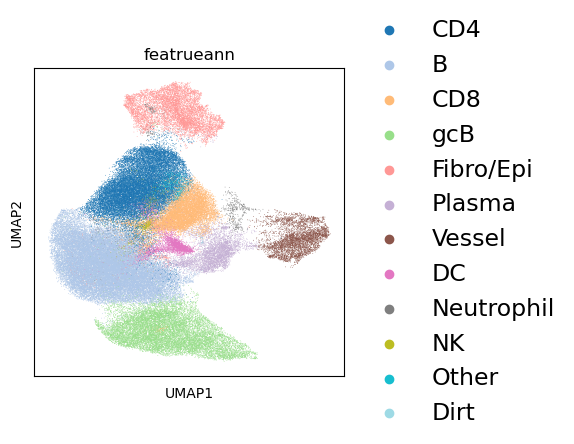

In [66]:
# plot
plt.rcParams["figure.figsize"] = (4, 4)
feature_adata.obs['featrueann'] = df_clean['feature_label_res1_ann'].values
sc.pl.umap(feature_adata, color='featrueann', legend_fontsize=17, show=False, palette='tab20')

In [67]:
df_clean.to_csv('../data/save_tonsil_ann_0325.csv')